In [1]:
using Pkg; Pkg.add("ControlSystemIdentification"); Pkg.add("Optim"); Pkg.add("Plots")

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/research/ao/ttsysid/Project.toml`
  No Changes to `~/research/ao/ttsysid/Manifest.toml`
   Resolving package versions...
    Updating `~/research/ao/ttsysid/Project.toml`
  [429524aa] + Optim v1.3.0
  No Changes to `~/research/ao/ttsysid/Manifest.toml`
   Resolving package versions...
    Updating `~/research/ao/ttsysid/Project.toml`
  [91a5bcdd] + Plots v1.16.5
  No Changes to `~/research/ao/ttsysid/Manifest.toml`


In this notebook, we will explore system identification of an LTI state-space model using [ControlSystemIdentification.jl](https://github.com/baggepinnen/ControlSystemIdentification.jl)
Before any identification can begin, we need to load all the relevant packages. The package Optim does the heavy lifting under the hood, and we load it to be able to s

In [2]:
using ControlSystemIdentification, ControlSystems, Optim, Plots
using Random, LinearAlgebra
default(size=(500,280))

We start by creating a system to use as the subject of identification

 * Status: success

 * Candidate solution
    Final objective value:     5.330754e-18

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 1.77e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.31e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.26e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.37e+02 ≰ 0.0e+00
    |g(x)|                 = 9.82e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    68
    f(x) calls:    201
    ∇f(x) calls:   201



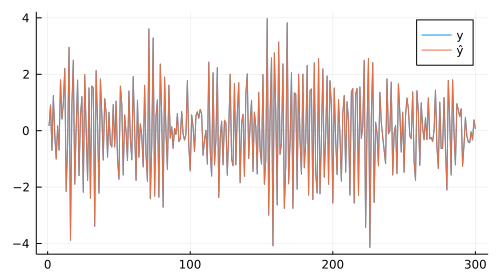

In [15]:
function generate_system(nx,ny,nu)
    A   = randn(nx,nx)
    A   = A - A'
    A  -= 0.1I
    A   = exp(A)
    B   = randn(nx,nu)
    C   = randn(ny,nx)
    sys = ss(A,B,C,0,1)
end

Random.seed!(5)
T   = 300                       # Number of time steps
nx  = 3                         # Number of poles in the true system
nu  = 1                         # Number of control inputs
ny  = 1                         # Number of outputs
x0  = randn(nx)                 # Initial state
sim(sys,u,x0=x0) = lsim(sys, u', 1:T, x0=x0)[1]' # Helper function
sys = generate_system(nx,nu,ny)
u   = randn(nu,T)               # Generate random input
y   = sim(sys, u, x0)           # Simulate system
d   = iddata(y,u,1)

sysh,x0h,opt = pem(d, nx=nx) # Estimate model

yh = predict(sysh, d, x0h)   # Predict using estimated model
plot([y; yh]', lab=["y" "ŷ"])  # Plot prediction and true output

In [13]:
@which pem

ControlSystemIdentification

We could also use the function `predplot` to plot the predicted output together with the measurements.

In the example above, there was no noise on the measurement signal. This is of course not a realistic scenario, and we can increase the realism by simulating some measurement noise

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     3.536110e-02

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 1.36e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.70e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.18e-08 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.03e-06 ≰ 0.0e+00
    |g(x)|                 = 1.02e+05 ≰ 1.0e-08

 * Work counters
    Seconds run:   9  (vs limit Inf)
    Iterations:    400
    f(x) calls:    4427
    ∇f(x) calls:   4427



┌ Warning: Estimated system does not have a stable prediction filter (A-KC)
└ @ ControlSystemIdentification /Users/adityasengupta/.julia/packages/ControlSystemIdentification/tbM2X/src/pem.jl:110
┌ Info: Stabilizing predictor
└ @ ControlSystemIdentification /Users/adityasengupta/.julia/packages/ControlSystemIdentification/tbM2X/src/pem.jl:112


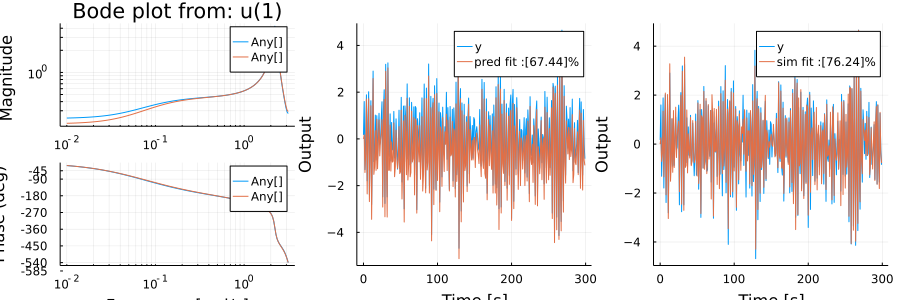

In [19]:
# Both noises
σu = 0.2
σy = 0.2

sysn = generate_system(nx,ny,ny)

u  = randn(nu,T)
un = u + sim(sysn, σu*randn(size(u)),0*x0)
y  = sim(sys, un, x0)
yn = y + sim(sysn, σy*randn(size(u)),0*x0)
dn = iddata(yn, un, 1)
sysh,x0h,opt = pem(dn,nx=nx+1, iterations=400)
f1 = bodeplot([sys,ss(sysh)], lab=[])
f2 = predplot(sysh,dn,x0h)
f3 = simplot(sysh,dn,x0h)
plot(f1,f2,f3, layout=(1,3), size=(900,300))

We can also optimize other metrics, such as the sum of absolute errors. One can also add a regularization function:

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     1.788654e-01

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 4.05e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.97e-04 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.37e-07 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.89e-06 ≰ 0.0e+00
    |g(x)|                 = 2.37e-02 ≰ 1.0e-08

 * Work counters
    Seconds run:   3  (vs limit Inf)
    Iterations:    1000
    f(x) calls:    2732
    ∇f(x) calls:   2732



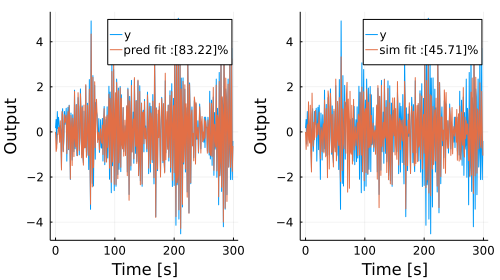

In [20]:
u  = randn(nu,T)
un = u + sim(sysn, σu*randn(size(u)),0*x0)
y  = sim(sys, un, x0)
yn = y + sim(sysn, σy*randn(size(u)),0*x0)
d = iddata(y, u, 1)
dn = iddata(yn, un, 1)
sysh,x0h,opt = pem(dn,nx=nx, metric=e->sum(abs,e), regularizer=p->(0.1/T)*norm(p))
plot(predplot(sysh,d,x0h),simplot(sysh,d,x0h))

We now create both test data and validation data and fit 4 different models of increasing order.

In [21]:
σy = 0.5
sim(sys,u) = lsim(sys, u', 1:T)[1]'
sys = tf(1,[1,2*0.1,0.1])
sysn = tf(σy,[1,2*0.1,0.3])

# Training data
u  = randn(nu,T)
un = u + 0.1randn(size(u))
y  = sim(sys, u)
yn = y + sim(sysn, σy*randn(size(u)))
dn = iddata(yn, un, 1)

# Validation data
uv  = randn(nu,T)
yv  = sim(sys, uv)
ynv = yv + sim(sysn, σy*randn(size(uv)))
dnv = iddata(ynv, uv, 1)

InputOutput data of length 300 with 1 outputs and 1 inputs

The flag `difficult=true` causes the function `pem` to use a global optimizer to find a good initial guess. This makes the optimization problem take a bit longer.

In [22]:
# fit 4 different models
res = [pem(dn,nx=nx, iterations=50, difficult=true) for nx = 1:4]

 * Status: success

 * Candidate solution
    Final objective value:     7.912155e-01

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 4.17e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.24e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.33e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.21e-16 ≰ 0.0e+00
    |g(x)|                 = 3.99e-11 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    13
    f(x) calls:    33
    ∇f(x) calls:   33

 * Status: success

 * Candidate solution
    Final objective value:     5.480759e-02

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 3.83e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.13e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 5.81e-11 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    46
    f(x) calls:    13

4-element Vector{Tuple{StateSpaceNoise{Float64, Base.ReshapedArray{Float64, 2, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}, Tuple{}}}, Vector{Float64}, Optim.MultivariateOptimizationResults{BFGS{LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Nothing, Nothing, Flat}, Float64, Tx, Float64, Float64, Vector{OptimizationState{Float64, BFGS{LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Nothing, Nothing, Flat}}}, Bool, NamedTuple{(:f_limit_reached, :g_limit_reached, :h_limit_reached, :time_limit, :callback, :f_increased), NTuple{6, Bool}}} where Tx}}:
 (StateSpaceNoise{Float64, Base.ReshapedArray{Float64, 2, SubArray{Float64, 1, Vector{Float64}, Tuple{UnitRange{Int64}}, true}, Tuple{}}}
A = 
 0.938251434912448
B = 
 0.07615819036878652
C = 
 1.0
D = 
 0.0

Sample Time: Discrete{Float64}(1.0) (seconds)
Discrete-time state-space model, [0.4076933340319993],  * Status: success

 * 

We can inspect the estimated noise model and compare it to the true noise system

┌ Warning: This call is deprecated due to ambiguity, use covar(ss(D), R) or covar(ss(D, Ts), R) instead
└ @ ControlSystems /Users/adityasengupta/.julia/packages/ControlSystems/D98Nv/src/ControlSystems.jl:173


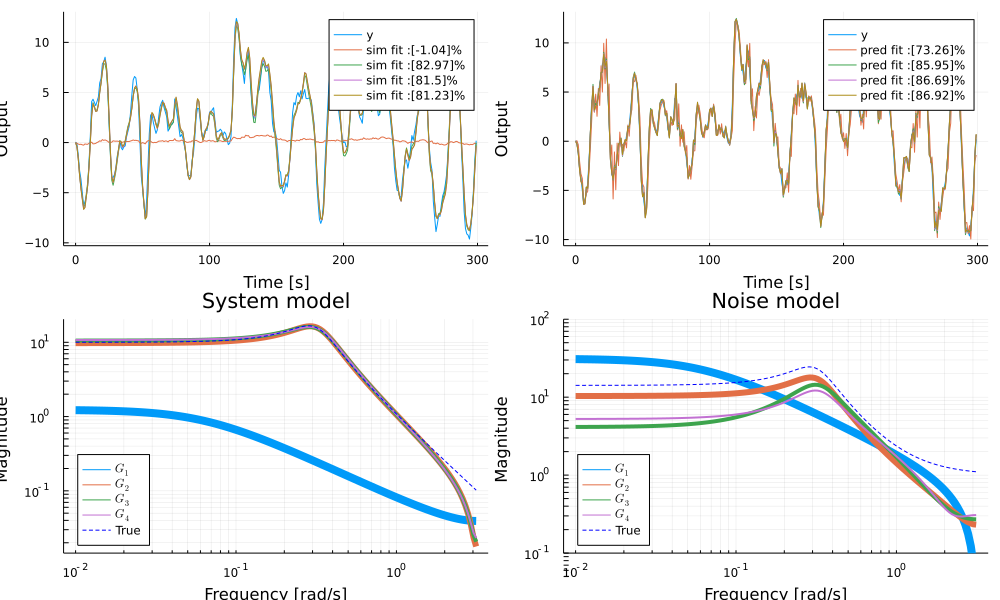

In [23]:
ω = exp10.(range(-2, stop=log10(pi), length=150))
fig = plot(layout=4, size=(1000,600))
for i in eachindex(res)
    (sysh,x0h,opt) = res[i]
    simplot!(sysh,dnv,x0h; subplot=1, ploty=i==1)
    predplot!(sysh,dnv,x0h; subplot=2, ploty=i==1)
end
bodeplot!(ss.(getindex.(res,1)), ω, plotphase=false, subplot=3, title="Process", linewidth=2*[4 3 2 1])
bodeplot!(ControlSystems.innovation_form.(getindex.(res,1)), ω, plotphase=false, subplot=4, linewidth=2*[4 3 2 1])
bodeplot!(sys, ω, plotphase=false, subplot=3, lab="True", linecolor=:blue, l=:dash, legend = :bottomleft, title="System model")
bodeplot!(ControlSystems.innovation_form(ss(sys),syse=ss(sysn), R2=σy^2*I), ω, plotphase=false, subplot=4, lab="True", linecolor=:blue, l=:dash, ylims=(0.1, 100), legend = :bottomleft, title="Noise model")

We see that adding more than two poles to the model does little to improve the prediction and simulation performance, it is thus a good idea to stick with the second-order model.